4章 さまざまなデータをPyTorchテンソルで表現する方法
* 4.1 画像データ
* 4.2 3次元データ
* 4.3 表形式データ(テーブルデータ)
* 4.4 時系列データ
* 4.5 テキストデータ


アイスブレイク
vpnの画像

CNN 画像(https://www.youtube.com/watch?v=vU-JfZNBdYU)

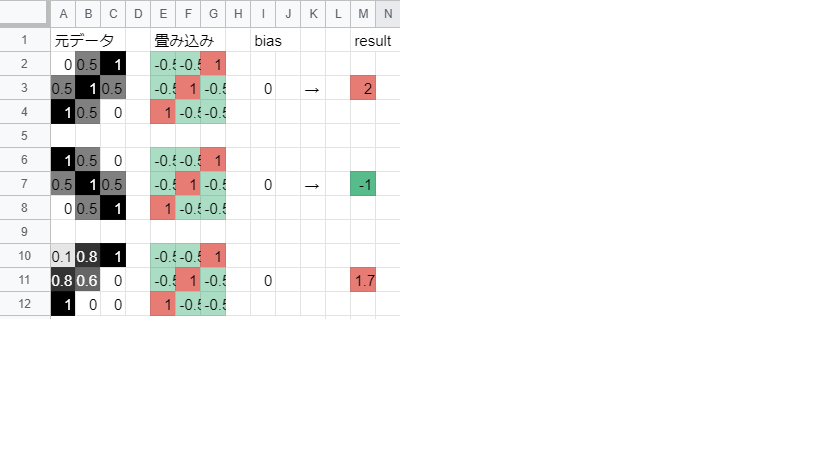

In [3]:
from IPython.display import Image
Image("./png/CNN.png")

4.1 画像データ

In [4]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, threshold=50)

ModuleNotFoundError: No module named 'torch'

In [ ]:
#チャネルの絵
Image("./png/Fig4_1.png")

In [6]:
import imageio

# GitHubのリポジトリから実行の場合
img_arr = imageio.imread('../data/image-dog/bobby.jpg')

# Google Colaboratoryの場合
# /data/p1ch4/image-dog/bobby.jpgを選択・アップロードしてください
# from google.colab import files

# uploade = files.upload()
# img_arr = imageio.imread('bobby.jpg')

img_arr.shape  # (720, 1280, 3) 　(高さ、幅、チャネル(RGBの3つ))


(720, 1280, 3)

Pytorchで画像を扱うときは、(チャネル、高さ、幅)の順になるように次元を変換する必要がある

In [7]:
img = torch.from_numpy(img_arr) # numpy配列からtorchテンソルに変換
out = img.permute(2, 0, 1)      # 次元を(チャネル、高さ、幅)に変換

In [8]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

In [10]:
import os

data_dir = '../data/p1ch4/image-cats/'
filenames = [name for name in os.listdir(data_dir)
             if os.path.splitext(name)[-1] == '.png']
for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3]  # <1>
    batch[i] = img_t

# <1> 
# ここでは前から3次元を取得するように指定しています。
# これは画像によっては透明度を表すアルファ値が4次元目にあるからです

正規化処理

In [11]:
batch = batch.float()
batch /= 255.0

平均0, 標準偏差1になるように、各値から平均を引き、それを標準偏差で割る

In [12]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

4.2 3次元データ

In [ ]:
#CTの絵
Image("./png/Fig4_2.png")

In [ ]:
torch.set_printoptions(edgeitems=2, threshold=50)

In [ ]:
dir_path = "../data/p1ch4/volumetric-dicom/2-LUNG 3.0  B70f-04083"

In [ ]:
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

In [ ]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)

vol.shape

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(vol_arr[50])

4.3 表形式データ

In [ ]:
torch.set_printoptions(edgeitems=2, precision=2, linewidth=75)

In [ ]:
import csv

# GitHubのリポジトリから実行の場合
wine_path = "../data/p1ch4/tabular-wine/winequality-white.csv"

# Google Colaboratoryの場合
# /data/p1ch4/tabular-wine/winequality-white.csvを選択・アップロードしてください
# from google.colab import files
# uploade = files.upload()

#wine_path = "winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
                         skiprows=1)
wineq_numpy

In [ ]:
col_list = next(csv.reader(open(wine_path), delimiter=';'))

wineq_numpy.shape, col_list

In [ ]:
wineq = torch.from_numpy(wineq_numpy)

wineq.shape, wineq.dtype

ワンホットエンコード One-hot encoding
* スコア1を(1,0,0,0,0,0,0,0,0,0), スコア2を(0,1,0,0,0,0,0,0,0,0),スコア10を(0,0,0,0,0,0,0,0,0,10)と表現

In [ ]:
target = wineq[:, -1] # スコアの列をtargetとして取り出す
target, target.shape

In [ ]:
target_onehot = torch.zeros(target.shape[0], 10) # 4898行 10列のゼロ行列作成
target_onehot.shape

one-hotを作りたいときは、scatterを利用する

In [ ]:
target_onehot.scatter_(1, target.unsqueeze(1), 1.0) # one-hotする次元、変換したいテンソル(列), 値
# _はテンソルの元を変える
# https://lilaboc.work/archives/23948835.html


In [ ]:
# 1行 4898列のテンソル、 4898行 1列のテンソル
target.unsqueeze(0).shape, target.unsqueeze(1).shape

wine の特徴データ

In [ ]:
data = wineq[:, :-1] # <1>
data, data.shape

In [ ]:
data_mean = torch.mean(data, dim=0)
data_mean,data_mean.shape

In [ ]:
data_var = torch.var(data, dim=0)
data_var, data_var.shape

In [ ]:
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized

In [ ]:
bad_indexes = target <= 3 # <1>
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum()

In [ ]:
bad_indexes

In [ ]:
bad_data = data[bad_indexes]
bad_data.shape

3つの品質カテゴリに分類する

In [ ]:
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)] # <1>
good_data = data[target >= 7]
bad_data.shape, mid_data.shape, good_data.shape

In [ ]:
# それぞれ、縦方向に平均をとる
bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)
bad_mean.shape, mid_mean.shape, good_mean.shape

In [ ]:
# enumerateはリスト形式の要素のインデックスと要素を同時に取得することができる
# https://techacademy.jp/magazine/15640
for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i, *args))

NO.6 total sulfur dioxide(二酸化硫黄の総量が特徴的)

In [ ]:
# 閾値を決める 上記No.6 Midの値
total_sulfur_threshold = 141.83
total_sulfur_data = data[:,6] # 6列目のみ取得
total_sulfur_data.shape

In [ ]:
# lt less thans でboolian型が戻る
# 閾値よりも小さいものを良質として予測
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold)
predicted_indexes.shape, predicted_indexes.dtype, predicted_indexes.sum()

In [ ]:
# 正解ラベルから品質が5以上のもの
actual_indexes = target > 5
actual_indexes.shape, actual_indexes.dtype, actual_indexes.sum()

In [ ]:
# 予測が正解したものの数
torch.sum(actual_indexes & predicted_indexes)

In [ ]:
# item()とすることで正解だった数を取り出す
n_matches = torch.sum(actual_indexes & predicted_indexes).item()
# 閾値よりも小さいものを良質として予測した数
n_predicted = torch.sum(predicted_indexes).item()
# 実際に5以上のワインの数
n_actual = torch.sum(actual_indexes).item()

n_matches, n_matches / n_predicted, n_matches / n_actual